# Ensemble Learning and Random Forests

Uses _wisdom of the crowd_.

If we aggregate the predictions of a group of predictors (such as classifiers and regressors), we will often get better predictions that with the best individual predictor.

A group of predictors is called an _ensemble_, and this technique is called _ensemble learning_, and an ensemble learning method is called an _ensemble method_.

As an example of an ensemble method, you can train a group of decision tree classifiers, each on different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble's prediction. Such an ensemble of decision trees is a _random forest_, and despite its simplicity, its one of the most powerful ML algorithms available today.

As discussed in Ch2, you will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor.

In this chapter, we will examine the most popular ensemble methods, including:-
- voting classifiers
- bagging and pasting ensembles
- random forests
- boosting ensembles
- stacking ensembles

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

**Voting Classifiers**

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. For e.g. you may have a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more.

A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble's prediction. This majority-vote classifier is called a _hard voting_ classifier.



Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

sk-learn providers a `VotingClassifier` class thats quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier.

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))
]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you fit a VotingClassifier, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute.

When you call the voting classifier’s predict() method, it performs hard voting. For example, the voting classifier predicts class 1 for the first instance of the test set, because two out of three classifiers predict that class

In [3]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

Now let’s look at the performance of the voting classifier on the test set:

In [5]:
voting_clf.score(X_test, y_test)

0.912

There you have it! The voting classifier outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called _soft voting_.

It often achieves higher performance than hard voting because it gives
more weight to highly confident votes.

All you need to do is set the voting classifier’s voting hyperparameter to "soft", and **ensure that all classifiers can estimate class probabilities**. This is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). Let’s try that:

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

We reach 92% accuracy simply by using soft voting—not bad!

**Bagging and Pasting**

Previous approach used classifers trained by very different training algorithms to obtain a diverse set of classifiers.

Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set.
- _bagging_: When sampling is performed with replacement (short for "bootstrap aggregating")
    - imagine picking a card randomly from a deck, writing it down, then placing it back in the deck before picking the next card: the same card could be sampled multiple times
    - in statistics, resampling with replacement is called _bootstrapping_.
- _pasting_: When sampling is performed without replacement

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure 7-4.

Once all the predictors are trained, the ensemble can make a prediction for a new instance by aggregating the predictions of all predictors. 
- for classification:- the aggregation function is typically the _statistical mode_ (i.e. the most frequent prediction, just like with a hard voting classifier), 
- for regression:- the aggregate function is the average

The predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons bagging and pasting are such popular methods. They scale very well.

**Bagging and Pasting in sk-learn**

sk-learn offers simple APIs for both bagging and pasting
- `BaggingClassifier` for classification
- `BaggingRegressor` for regression

The following code trains an ensemble of 500 decision tree classifiers, each is trained on 100 training instances randomly sampled from the training set with replacement (i.e. using bagging, can set `bootstrape=False` if you want to use pasting). The `n_jobs` parameters is for specifying number of CPU cores to use for training and predictions (-1 means use all cores).


In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

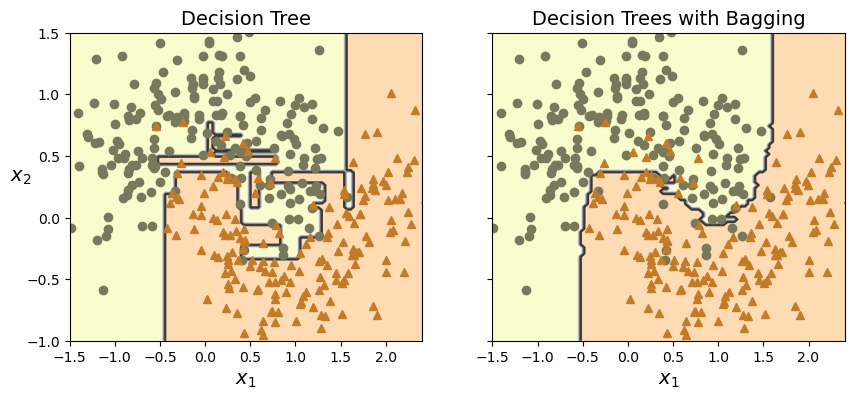

In [12]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

As you can see, the ensembles predictions will likely generalize much better than a single decision tree's predictions.

Overall bagging results in better models, but if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

**Out-of-bag Evaluation**

With bagging, some training instances may be sampled several times for any given predictor, while others may not be sampled at all.

By default a BaggingClassifier samples `m` training instances with replacement (bootstrap=True), where `m` is the size of the training set. With this process, it can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor.

The remaining 37% of the training instances that are not sampled are called out-of-bag (OOB) instances. Note that they are not the same 37% for all predictors.

A bagging ensemble can be evaluated using these OOB instances, without the need for a separate validation set. Indeed, if there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance.

Once you have a prediction for each instance, you can compute the ensemble's prediction accuracy (or any other metric).

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic OOB evaluation after training. The following code demonstrates this. The resulting evaluation score is available in the `oob_score_` attribute:

In [13]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to this OOB evaluation, this BaggingClassifier is likely to achieve about 89.6% accuracy on the test set. Let’s verify this

In [15]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The OOB decision function for each training instance is also available through the `oob_decision_function_` attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the class probabilities for each training instance.

In [16]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

in example above, the OOB evaluation estimates that the first training instance has a 67.6% probability of belonging to the positive class and a 32.4% probability of belonging to the negative class.

**Random Patches and Random Subspaces**

The `BaggingClassifier` class supports sampling the features as well. Meaning each predictor will be trained on a random subset of the input features. 

Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap` but for feature sampling instead of instance sampling.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images), as it can considerably speed up training.

Sampling both training instances and features is called the `random patches` method. Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features=True` and/or `max_features=<a value smaller than 1.0>`) is called the `random_subspaces` method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

**Random Forests**

As we have discussed, a random forest is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set.

Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForesetClassifier` which is optimized for decision trees.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees. (By default it samples `sqrt(n)` features (where `n` is total num of features). The algorithm results in greater tree diversity, which trades higher bias for lower variance. 

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [20]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

**Extra-Trees**

When you are growing a tree in a random forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular decision trees do). For this, simply set `splitter="random"` when creating a `DecisionTreeClassifier`

A forest of such extremely random trees is called an extremely randomized trees (or extra-trees for short) ensemble. Once again, this technique trades more bias for a lower variance. It also makes extra-trees classifiers much faster to train than regular random forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an extra-trees classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class, except `bootstrap` defaults to `False`. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class, except `bootstrap` defaults to `False`.

**Feature Importance**

Another great quality of random forests is that they make it easy to measure the relative importance of each feature. 

As we saw in chapter 6, in decision trees, the impurity is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it. sk-learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest.

sk-learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the `feature_importances_` variable. For example, the following code trains a `RandomForestClassifier` on the iris dataset (introduced in Chapter 4) and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively)

In [21]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similarly if you train a random forest classifier on the MNIST dataset (from chapter 3) and plot each pixel's importance, you get the image represented below.

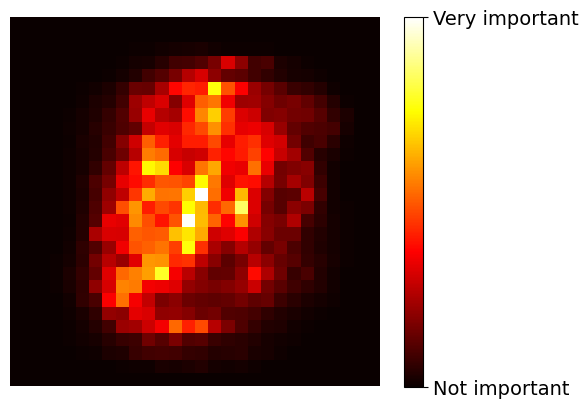

In [22]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
# save_fig("mnist_feature_importance_plot")
plt.show()

Random forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

**Boosting**

Refers to any ensemble method that can combine several weak learners into a strong learner. This idea for most boosting methods is to train predictors sequentially, each trying to correct is predecessor. There are many boosting methods available, but by far the most popular are _AdabBoost_ and _gradient boosting_.

**AdaBoost**

- short for adaptive boosting
- technique:
  - one way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfit.
  - this results in new predictors focusing more and more on hard cases
- example:
  - the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set.
  - the algorithm then increases the relative weight of misclassifier training instances.
  - then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights
  - and so on.
- Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.
- one drawback for sequential training is that it cannot be parallelized, so it doesnt scale as well as bagging and pasting

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

**Gradient Boosting**

- this method tries to fit the new predictor to the _residual errors_ made by the previous predictor (instead of tweaking the instance weights at every iteration like Adaboost)
- example, using decision trees as the base predictor
  - this method is called _gradient tree boosting_ or _gradient boosted regression trees_ (GBRT).
  - First lets generate a noise quadratic dataset and fit a `DecisionTreeRegressor` to it

In [24]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

  - next we'll train a second `DecisionTreeRegressor` on the residual errors made by the first predictor

In [25]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

And then we’ll train a third regressor on the residual errors made by the second predictor:

In [26]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [27]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

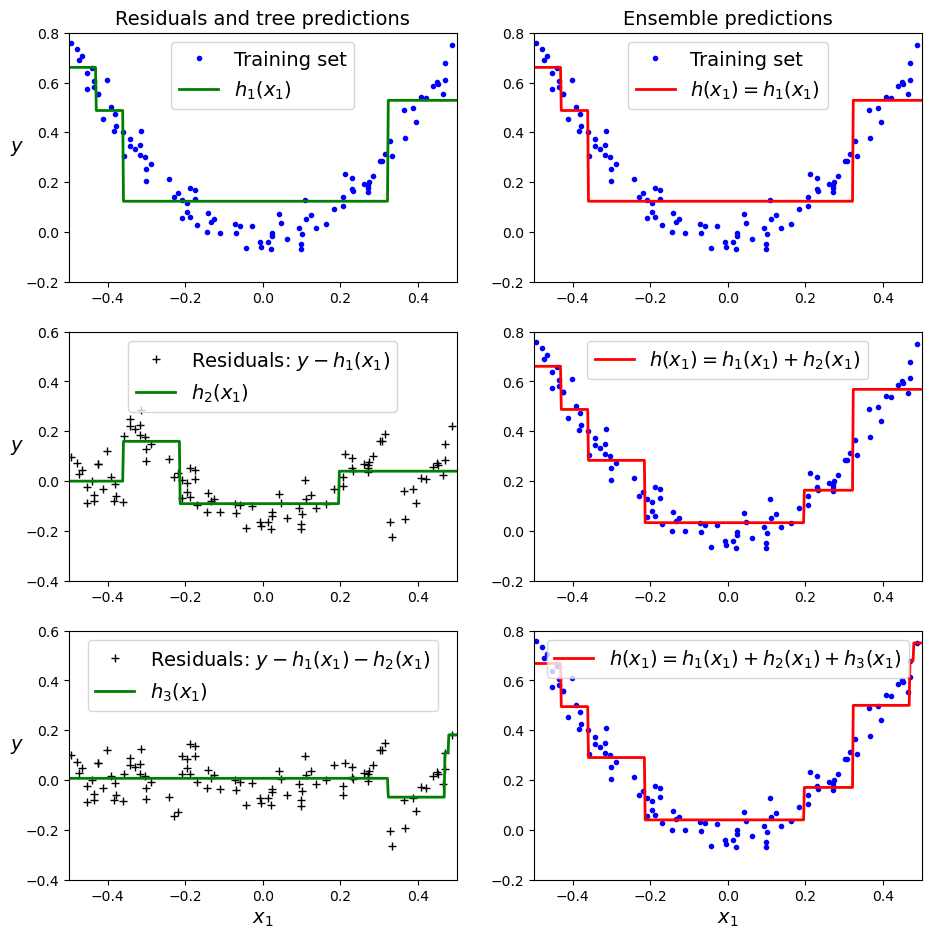

In [28]:

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

# save_fig("gradient_boosting_plot")
plt.show()

Above figure shows the predictions of these 3 trees in the left column, and the ensemble's predictions in the right column.
- first row - the ensemble has just one tree so its predictions are exactly the same as the tree's predictions
- second and third row - the ensemble's predictions are the sum of the previous rows trees, and that the predictions gradually get better

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

# creates the same ensemble as the previous example

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Much like the `RandomForestRegressor` class, it has hyperparameters to
control the growth of decision trees (e.g., `max_depth`, `min_samples_leaf`), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.05, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called `shrinkage`.

If you add too many trees, the GBRT would start to overfit the training set.

To find the optimal number of trees, you could perform cross-validation using `GridSearchCV` or `RandomizedSearchCV`, as usual, but there’s a simpler way: if you set the `n_iter_no_change hyperparameter` to an integer value, say `10`, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help. This is simply early stopping (introduced in Chapter 4), but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. Let’s train the ensemble using early stopping:

In [31]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

If you set `n_iter_no_change` too low, training may stop too early and the model will underfit. But if you set it too high, it will overfit instead. We also set a fairly small learning rate and a high number of estimators, but the actual number of estimators in the trained ensemble is much lower, thanks to early stopping:

In [32]:
gbrt_best.n_estimators_

92

**Histogram-Based Gradient Boosting** - TODO

**Stacking**

Instead of using functions (such as hard voting) to agggregate the predictions of all predictors in an ensemble, why dont we train a model to perform this aggregation? 

- figure 7-11 shows such an ensemble doing a regression task on a new instance
- each of the bottom 3 predictors predict a different value (3.1, 2.7, 2.9)
- the final predictor (called a _blender_ or _meta learner_) takes these predictions as inputs and makes the final prediction (3.0)
- to train the blender, you first need to build the blending training set.
- you can use the cross_val_predict() on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set
    - then use these as input features to train the blender
    - the targets can simply be copied from the original training set.
- note:- regardless of the number of features, the blending training set will contain one input feature per predictor (three in the above figure 7-11 example)
- Once the blender is trained, the base predictors are retrained one last time on the full original training set

It is actually possible to train several different blenders this way (e.g. one using linear regression, another using random forest regression) to get a whole layer of blenders, and then add another blender on top of that to produce the final prediction.

Scikit-Learn provides two classes for stacking ensembles: `StackingClassifier` and `StackingRegressor`. For example, we can replace the `VotingClassifier` we used at the beginning of this chapter on the moons dataset with a `StackingClassifier`

In [33]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5 # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [34]:
stacking_clf.score(X_test, y_test)

0.928